# Automatic differentiation capabilities in Collimator

Automatic differentiation is a powerful tool for computing derivatives of functions. It is used in many fields, including machine learning, optimization, and scientific computing. In this notebook, we will demonstrate how automatic differentiation can be used in Collimator.


In [1]:
import control

import jax
import jax.numpy as jnp
from jax import lax
from functools import partial

from scipy.optimize import minimize, root, least_squares
from jax.scipy.optimize import minimize as minimize_jax
from cyipopt import minimize_ipopt  # NOTE: requires IPOPT to be installed

import collimator
from collimator import logging

logging.set_log_level(logging.ERROR)
from collimator.library import *

from collimator.simulation import SimulatorOptions

from collimator.logging import logger

import matplotlib.pyplot as plt

## Nonlinear state-space model

A general nonlinear state-space model with state vector $\mathbf{x}$, measurement vector $\mathbf{y}$, and control vector $\mathbf{u}$ can be written as follows:

**State Evolution (forward model)**
$$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u})
$$
**Measurement/Output function (observation model)**
$$
\mathbf{y} = \mathbf{g}(\mathbf{x}, \mathbf{u}).
$$

## Equilibrium points and linearization

For linearization, we consider a first-order Taylor series expansion of the functions $\mathbf{f}$ and $\mathbf{g}$ around $(\bar{\mathbf{x}},\bar{\mathbf{u}})$. This gives

\begin{align}
\mathbf{f}(\mathbf{x},\mathbf{u}) &\approx \mathbf{f}(\bar{\mathbf{x}},\bar{\mathbf{u}}) + \mathbf{A} \delta \mathbf{x} + \mathbf{B} \delta \mathbf{u} \\
\mathbf{g}(\mathbf{x},\mathbf{u}) &\approx \mathbf{g}(\bar{\mathbf{x}},\bar{\mathbf{u}}) + \mathbf{C} \delta \mathbf{x} + \mathbf{D} \delta \mathbf{u},
\end{align}

where $\mathbf{A, B, C}$, and $\mathbf{D}$ are the Jacobian matrices:

\begin{equation}
\begin{matrix}
\mathbf{A} = \dfrac{\partial \mathbf{f}}{\partial \mathbf{x}} \bigg|_{\bar{\mathbf{x}},\bar{\mathbf{u}}} &
\mathbf{B} = \dfrac{\partial \mathbf{f}}{\partial \mathbf{u}} \bigg|_{\bar{\mathbf{x}},\bar{\mathbf{u}}} \\[10pt]
\mathbf{C} = \dfrac{\partial \mathbf{g}}{\partial \mathbf{x}} \bigg|_{\bar{\mathbf{x}},\bar{\mathbf{u}}} &
\mathbf{D} = \dfrac{\partial \mathbf{g}}{\partial \mathbf{u}} \bigg|_{\bar{\mathbf{x}},\bar{\mathbf{u}}}
\end{matrix},
\end{equation}

and 
$$\delta \mathbf{x} = \mathbf{x} - \bar{\mathbf{x}},$$
$$\delta \mathbf{u} = \mathbf{u} - \bar{\mathbf{u}}.$$

Additionally, by defining
$$\delta \mathbf{y} = \mathbf{y} - \mathbf{g}(\bar{\mathbf{x}},\bar{\mathbf{u}}),$$

and considering $(\bar{\mathbf{x}},\bar{\mathbf{u}})$ to be an *equilibrium point* (also known as a *fixed point*) where $\mathbf{f}(\bar{\mathbf{x}},\bar{\mathbf{u}})=\mathbf{0}$, the linearized state-space model (i.e. the linearized forward and observation models) in $\delta \mathbf{x}$ and $\delta \mathbf{y}$ become:

\begin{align}
\dot{\delta\mathbf{x}} &= \mathbf{A}\, \delta \mathbf{x} + \mathbf{B}\, \delta \mathbf{u} \\
{\delta\mathbf{y}} &= \mathbf{C}\, \delta \mathbf{x} + \mathbf{D}\, \delta \mathbf{u}
\end{align}

Often, the $\delta$ notation are ommited and a change of origin is implied to write the linearized state-space model as:

\begin{align}
\dot{\mathbf{x}} &= \mathbf{A}  \mathbf{x} + \mathbf{B}  \mathbf{u}  \\
{\mathbf{y}} &= \mathbf{C}  \mathbf{x} + \mathbf{D}  \mathbf{u}.
\end{align}


For two examples plant models---Pendulum and Planar Quadrotor---we demonstrate how to (i) find equilibrium points, and (ii) linearize the plant around the equilibrium points.

### Example 1: Pendulum plant

Consider a pendulum with a rigid rod of length $ L $ and a point mass $ m $ at the end. The pendulum is actuated by a torque $ u $ applied at the pivot. The damping coefficient is $b$. A schematic is shown below

<img src="../media/pendulum.png" alt="pendulum" style="width: 300px;"/>

With angular velocity $ \omega = \dot{\theta} $, and the state vector $\mathbf{x} = [\theta, \omega]^T$, the dynamics of the pendulum are given by:

\begin{equation}
\mathbf{\dot{x}} = 
\begin{bmatrix}
\dot{\theta} \\ \dot{\omega}
\end{bmatrix} = 
\mathbf{f(x,u)} = 
\begin{bmatrix}
{f_1\mathbf{(x,u)}} \\ {f_2\mathbf{(x,u)}}
\end{bmatrix} = 
\begin{bmatrix}
\omega \\ -\dfrac{g}{L} \sin(\theta) - \dfrac{b}{m L^2} \omega +  \dfrac{u}{m L^2}
\end{bmatrix},
\end{equation}

where $ g $ is the acceleration due to gravity. Assume that the output of the Pendulum plant is only the angle $\theta$. Thus

$$\mathbf{y} = \mathbf{g(x,u)} = [g_1\mathbf{(x,u)}] =  [\theta].$$


For linearization, the Jacobian matrices [see note on linearization and discretisation] for $\mathbf{f}(\mathbf{x,u})$ at an equilibrium point $(\bar{\mathbf{x}},\bar{\mathbf{u}})$ can be computed as follows:

$$ \mathbf{A} = \dfrac{\partial \mathbf{f}}{\partial \mathbf{x}}\bigg|_{\bar{\mathbf{x}},\bar{\mathbf{u}}} = \begin{bmatrix} \dfrac{\partial f_1}{\partial \theta} & \dfrac{\partial f_1}{\partial \omega} \\[5pt] \dfrac{\partial f_2}{\partial \theta} & \dfrac{\partial f_2}{\partial \omega} \end{bmatrix} =
\begin{bmatrix} 0 & 1 \\ -\dfrac{g\cos(\bar{\theta})}{L} & -\dfrac{b}{mL^2} \end{bmatrix}
$$

$$
\mathbf{B} =
\dfrac{\partial \mathbf{f}}{\partial \mathbf{u}}\bigg|_{\bar{\mathbf{x}},\bar{\mathbf{u}}} =
\begin{bmatrix} 
\dfrac{\partial f_1}{\partial u}\\[5pt]
\dfrac{\partial f_2}{\partial u}
\end{bmatrix} = 
\begin{bmatrix} 0 \\ \dfrac{1}{mL^2} \end{bmatrix}
$$

Similarly, we can compute the Jacobain matrices for the observation operator:

$$
\mathbf{C} = \dfrac{\partial \mathbf{g}}{\partial \mathbf{x}} \bigg|_{\bar{\mathbf{x}},\bar{\mathbf{u}}} = 
\begin{bmatrix} \dfrac{\partial g_1}{\partial \theta} & \dfrac{\partial g_1}{\partial \omega} \end{bmatrix} =
[1, 0]\\[10pt]
$$


$$
\mathbf{D} = \dfrac{\partial \mathbf{g}}{\partial \mathbf{u}} \bigg|_{\bar{\mathbf{x}},\bar{\mathbf{u}}} = 
\begin{bmatrix} \dfrac{\partial g_1}{\partial u}\end{bmatrix} = [0].
$$

#### Finding equilibrium points of the Pendulum plant

While it is easy to see that the Pendulum has two equilibrium points, one at the up-swing position $ \mathbf{\bar{x}} = \begin{bmatrix} \pi &  0 \end{bmatrix}^T $ and the other at the down-swing position $ \mathbf{\bar{x}} = \begin{bmatrix} 0 & 0 \end{bmatrix}^T $, with the control input $\mathbf{\bar{u}} = 0$ for both points, it is instructive to see how one can find these points programatically. The general appraoch is to create a function that takes $\mathbf{x}$ and $\mathbf{u}$ and outputs the $\mathbf{f(x,u)}$, and then use an optimizer to minimize some suitable norm of $\mathbf{f(x,u)}$. However, in this case there are infinitely many solutions as for $\omega = 0$ any point satisfying $\frac{g \sin (\theta)}{L} = \frac{u}{m L^2}$ is an equilibrium point. For a fixed $u$, for example $u=0$, we can solve an optimization problem and find the two equilibrium points of the 'up' and 'down' orientations.

**Using JAX minimizers**

In [2]:
from collimator.models import Pendulum
from jax.flatten_util import ravel_pytree

plant = Pendulum(input_port=True, full_state_output=False)  # Create plant

x_0 = jnp.array([0.1, 0.1])  # guess for optimization near 'down' orientation
u_eq = jnp.array([0.0])  # fixed

# create a base context with any value of input, here u_0
plant.input_ports[0].fix_value(u_eq)
context = plant.create_context()


# Map from state to state derivatives
def f(x, context):
    context = context.with_continuous_state(x)
    xdot = plant.eval_time_derivatives(context)
    # return square of the L2 norm of xdot as objective
    # to minimize
    return jnp.dot(xdot, xdot)


# Create the objective function for optimizers (one input only)
opt_func = jax.jit(partial(f, context=context))

# use JAX's mimimize routine to find the optimum
res = minimize_jax(opt_func, x_0, method="BFGS")
x_eq = res.x
print(f"{x_eq=}")

x_eq=Array([-2.40765351e-09, -2.55016218e-08], dtype=float64)


If we start form a guess closer to the 'up' orientation, we will converge to the other equilibrium point.

In [3]:
x_0 = jnp.array([jnp.pi + 0.1, 0.1])

res = minimize_jax(opt_func, x_0, method="BFGS")
x_eq = res.x
print(f"{x_eq=}")

x_eq=Array([ 3.14159265e+00, -2.55016218e-08], dtype=float64)


**Using scipy minimizers:**
We may also utilize `scipy` minimization routines, and provide an autodifferentiated jacobian function

In [4]:
# Down orientation
x_0 = jnp.array([0.1, 0.1])
res = minimize(opt_func, x_0, jac=jax.jacfwd(opt_func), method="BFGS")
res.x

array([ 5.79707512e-09, -3.64694947e-08])

In [5]:
# Up orientation
x_0 = jnp.array([jnp.pi - 0.1, 0.1])
res = minimize(opt_func, x_0, jac=jax.jacfwd(opt_func), method="BFGS")
res.x

array([ 3.14159265e+00, -3.64694947e-08])

**Using external minimizers such as IPOPT:**
We can also use external optimization libraries such as `IPOPT`

NOTE This requires IPOPT to be installed, which is not currently a default dependency (try `pip install ipopt` locally).

In [6]:
bounds = [
    (-jnp.pi, jnp.pi),
    (-10.0, 10.0),
]  # lower and upper bounds on the optimization variables
x0 = jnp.array([jnp.pi - 0.1, 0.1])
res = minimize_ipopt(opt_func, jac=jax.jit(jax.grad(opt_func)), x0=x0, bounds=bounds)
res.x


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



array([3.14159138e+00, 2.61157312e-17])

**Using scipy root finding:**
Another, more direct way to solve the problem is to use scipy.optimize.root.  Now the objective function isn't the norm of the right-hand-side of the ODE, but the ODE vector itself. The root-finding algorithm looks for zeros of the function $\dot{x} = f(x) = 0$

In [7]:
def ode(x, context):
    context = context.with_continuous_state(x)
    xdot = plant.eval_time_derivatives(context)
    # return square of the L2 norm of xdot as objective
    # to minimize
    return xdot


opt_func = jax.jit(partial(ode, context=context))

In [8]:
# Down position
x_0 = jnp.array([0.1, 0.1])
res = root(opt_func, x_0, jac=jax.jacfwd(opt_func))
res.x

array([0., 0.])

In [9]:
# Up position
x_0 = jnp.array([jnp.pi - 0.1, 0.1])
res = root(opt_func, x_0, jac=jax.jacfwd(opt_func))
res.x

array([ 3.14159265e+00, -2.23223673e-43])

#### Linearization of the Pendulum plant

Once we have determined the equilibrium points, we can linearize the plant around the equilibrium points.

Collimator provides a utility `library.linearize` to automatically perform linearization of a plant around an equilibrium. However, let's first look at doing this from scratch.

In [10]:
plant = Pendulum(input_port=True, full_state_output=False)  # Create plant

# Equilibrium point for the down orientation
u_eq = jnp.array([0.0])
x_eq = jnp.array([0.0, 0.0])

# create a base context
with plant.input_ports[0].fixed(u_eq):
    context = plant.create_context()


# Map from (state, inputs) to (state derivatives, outputs)
@jax.jit
def f(x, u, context):
    with plant.input_ports[0].fixed(u):
        context = context.with_continuous_state(x)
        xdot = plant.eval_time_derivatives(context)
        y = plant.output_ports[0].eval(context)
    return xdot, y


calc_jacobians = jax.jacfwd(f, argnums=(0, 1))
jacobians_eq = calc_jacobians(x_eq, u_eq, context)

For very large-scale systems we would not need to form the matrices explicitly in linearization, but would use matrix-free linear operators to define an LTI system.  The explicit matrices could be extracted on user command by evaluating standard basis vectors.  However, for this simple example we can just pull out the matrices by direct indexing:

In [11]:
A = jacobians_eq[0][0]
B = jacobians_eq[0][1]
C = jacobians_eq[1][0]
D = jacobians_eq[1][1]

print(f"{A=}")
print(f"{B=}")
print(f"{C=}")
print(f"{D=}")

lin_sys = control.ss(A, B, C, D)

# Visualize a state-space representation of the linear plant
lin_sys

A=Array([[ 0.  ,  1.  ],
       [-9.81,  0.  ]], dtype=float64)
B=Array([[0.],
       [1.]], dtype=float64)
C=Array([1., 0.], dtype=float64)
D=Array([0.], dtype=float64)


<LinearIOSystem:sys[2]:['u[0]']->['y[0]']>

Alternatively, one can use the `library.linearize` utility provided by Collimator, which linearizes a plant around a provided context. We demonstrate its usage below for the 'up' orientation.

In [12]:
# Equilibrium point for the up orientation
u_eq = jnp.array([0.0])
x_eq = jnp.array([jnp.pi, 0.0])

plant = Pendulum(input_port=True, full_state_output=False)  # Create plant

# Fix the input_port to u_eq through a context manager
with plant.input_ports[0].fixed(u_eq):
    # Create a base context
    base_context = plant.create_context()
    # Set the the continuous state to x_eq in the context
    eq_context = base_context.with_continuous_state(x_eq)
    # Call linearize for the pendulum plant and equilibrium context
    linear_plant = linearize(plant, eq_context)

A, B, C, D = linear_plant.A, linear_plant.B, linear_plant.C, linear_plant.D

# Visualize a state-space representation of the linear plant
linear_plant

<LinearIOSystem:sys[7]:['u[0]']->['y[0]']>

For very large-scale systems we would not need to form the matrices explicitly in linearization, but would use matrix-free linear operators to define an LTI system.  The explicit matrices could be extracted on user command by evaluating standard basis vectors.  However, for this simple example we can just pull out the matrices by direct indexing:

### Example 2: Equilibrium points and linearization of a Planar Quadrotor plant

A schematic of the planar quadrotor (see [1] for details) is shown below

<img src="../media/planar_quadrotor.png" alt="planar quadrotor" style="width: 400px;"/>

The quadrotor is of mass $m$, and the moment of inertia about the center of mass is $I_B$. The distance from the center of mass to the rotors is $r$. The angle of the quadrotor with respect to the horizontal is $\theta$. The forces applied by the two rotors are $u_1$ and $u_2$. The dynamics of the quadrotor can be described as:

\begin{align}
        m \ddot{x} &= -(u_1 + u_2)\sin\theta,\\
        m \ddot{y} &= (u_1 + u_2)\cos\theta - mg,\\
        I_B \,\ddot\theta &= r (u_1 - u_2).
        \end{align}

Implemenation as a system of first order differential equations leads to a state vector of size 6: $\mathbf{x} = [x, y, \theta, \dot{x}, \dot{y}, \dot{\theta}]$. The control input vector is of size 2: $\mathbf{u} = [u_1, u_2]$. To find the equilibrium points we can use a number of optimization methods and design the objective function specific to that method. Some examples are below.

**References**:
> [1] Russ Tedrake. Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (Course Notes for MIT 6.832). [Available online.](https://underactuated.csail.mit.edu/)

#### Equilibrium points of Planar Quadrotor

**Least squares:**
We can find the equilibrium points by the `scipy.optimize.least_squares`, which minimizes $\frac12 ||\mathbf{f(x,u)}||_2$, and expects a function returing $\mathbf{f(x,u)}$.

In [13]:
from collimator.models import PlanarQuadrotor

from jax.flatten_util import ravel_pytree

config = {"m": 1.0, "I_B": 1.0, "r": 0.5, "g": 9.81}  # quadrotor parameters

plant = PlanarQuadrotor(**config)  # Create plant

x_0 = jnp.zeros(6)  # guess for state vector
u_0 = jnp.zeros(2)  # guess for control vector

# create a base context with any value of input, here u_0
with plant.input_ports[0].fixed(u_0):
    context = plant.create_context()

# The optimization variables will be a flat array of (x,u)
# so create an unflatten function, that can get x and u separately
optvars_0, unflatten = ravel_pytree((x_0, u_0))


# Map from optimization variables to state derivatives
def f(optvars, context, unflatten):
    x, u = unflatten(optvars)
    with plant.input_ports[0].fixed(u):
        context = context.with_continuous_state(x)
        xdot = plant.eval_time_derivatives(context)
    return xdot


opt_func = jax.jit(partial(f, context=context, unflatten=unflatten))

opt_func(optvars_0)
# res = root(opt_func, optvars_0, jac=jax.jacfwd(opt_func), method="lm")

res = least_squares(opt_func, optvars_0, jac=jax.jacfwd(opt_func))
print(f"Root finding successful: {res.x}")
print(f"cost residual: {res.cost}")
x_eq, u_eq = unflatten(res.x)

print(f"weight/2 = {config['g']*config['m']/2}")

Root finding successful: [0.         0.         0.         0.         0.         0.
 4.90499999 4.90499999]
cost residual: 1.7467957663658344e-16
weight/2 = 4.905


The quadrotor is in equilibrium when the forces applied by the rotors are such that the quadrotor is hovering at a given height. The forces are then such that the weight of the quadrotor is balanced by the forces applied by the rotors. The equilibrium point is then given by:

$$ u_{eq} = \left[\frac{m g}{2}, \frac{m g}{2}\right], \quad x_{eq} = [x, y, 0, 0, 0, 0]. $$

In the equilibrium state, note that the coordinates of the quadrotor $x$ and $y$ are *arbitrary*, and the angle $\theta$ is zero (horizontal orientation at hover). Thus any chosen $(x, y)$ can be used to define the equilibrium point. In our optimization case, $(x,y)$ at equilibrium points will be determined by the initial guesses.

In [14]:
x_0 = jnp.array([5.0, 5.0, 0.0, 0.0, 0.0, 0.0])  # guess for state vector
u_0 = jnp.zeros(2)  # guess for control vector
optvars_0, unflatten = ravel_pytree((x_0, u_0))

res = least_squares(opt_func, optvars_0, jac=jax.jacfwd(opt_func))
print(f"Root finding successful: {res.x}")
print(f"cost residual: {res.cost}")
x_eq, u_eq = unflatten(res.x)

Root finding successful: [5.         5.         0.         0.         0.         0.
 4.90499999 4.90499999]
cost residual: 7.833734284324333e-17


**Minimize routines:**
We can also find the equilibrium points by the `scipy.optimize.minimize` (or alternatively JAX or IPOPT's minimization routines), by creating an objective function computing $||\mathbf{f(x,u)}||_2$ 

In [15]:
x_0 = jnp.zeros(6)  # guess for state vector
u_0 = jnp.zeros(2)  # guess for control vector

# create a base context with any value of input, here u_0
with plant.input_ports[0].fixed(u_0):
    context = plant.create_context()

# The optimization variables will be a flat array of (x,u)
# so create an unflatten function, that can get x and u separately
optvars_0, unflatten = ravel_pytree((x_0, u_0))


# Map from optimization variables to state derivatives
def f(optvars, context, unflatten):
    x, u = unflatten(optvars)
    with plant.input_ports[0].fixed(u):
        context = context.with_continuous_state(x)
        xdot = plant.eval_time_derivatives(context)
    return jnp.linalg.norm(xdot)


opt_func = jax.jit(partial(f, context=context, unflatten=unflatten))

opt_func(optvars_0)
# res = root(opt_func, optvars_0, jac=jax.jacfwd(opt_func), method="lm")

res = least_squares(opt_func, optvars_0, jac=jax.jacfwd(opt_func))
print(f"Root finding successful: {res.x}")
print(f"residual: {res.cost}")
x_eq, u_eq = unflatten(res.x)

print(f"weight/2 = {config['g']*config['m']/2}")

Root finding successful: [0.         0.         0.         0.         0.         0.
 4.90499999 4.90499999]
residual: 1.7467957663658344e-16
weight/2 = 4.905


**Root finding routines:**
We can also find the equilibrium points by the `scipy.optimize.root`. However, we now have to extend the function output so that there are as many equations as variables.  This is because the root-finding algorithm looks for zeros of the function $F(z) = 0$, where in this case $z = [x~u]$.  We can do this by just multiplying the inputs by zero to get the right dimensions

In [16]:
x_0 = jnp.zeros(6)  # guess for state vector
u_0 = jnp.zeros(2)  # guess for control vector

# create a base context with any value of input, here u_0
with plant.input_ports[0].fixed(u_0):
    context = plant.create_context()

# The optimization variables will be a flat array of (x,u)
# so create an unflatten function, that can get x and u separately
optvars_0, unflatten = ravel_pytree((x_0, u_0))


# Map from optimization variables to state derivatives
def f(optvars, context, unflatten):
    x, u = unflatten(optvars)
    with plant.input_ports[0].fixed(u):
        context = context.with_continuous_state(x)
        xdot = plant.eval_time_derivatives(context)
    residual, _ = ravel_pytree((xdot, 0 * u))
    return residual


opt_func = jax.jit(partial(f, context=context, unflatten=unflatten))

opt_func(optvars_0)
# res = root(opt_func, optvars_0, jac=jax.jacfwd(opt_func), method="lm")

res = least_squares(opt_func, optvars_0, jac=jax.jacfwd(opt_func))
print(f"Root finding successful: {res.x}")
print(f"least squares residual: {res.cost}")
x_eq, u_eq = unflatten(res.x)

print(f"weight/2 = {config['g']*config['m']/2}")

Root finding successful: [0.         0.         0.         0.         0.         0.
 4.90499999 4.90499999]
least squares residual: 1.7467957663658344e-16
weight/2 = 4.905


### Linearization of Planar Quadrotor

Once we have found an equirlibrium points, we can linearize the plant around them.

In [17]:
# Fix the input_port to u_eq through a context manager
with plant.input_ports[0].fixed(u_eq):
    # Create a base context
    base_context = plant.create_context()
    # Set the the continuous state to x_eq in the context
    eq_context = base_context.with_continuous_state(x_eq)
    # Call linearize for the pendulum plant and equilibrium context
    linear_plant = linearize(plant, eq_context)

A, B, C, D = linear_plant.A, linear_plant.B, linear_plant.C, linear_plant.D

print(f"{A=}")
print(f"{B=}")
print(f"{C=}")
print(f"{D=}")

A=Array([[ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.        ,  0.        , -9.80999998, -0.        , -0.        ,
        -0.        ],
       [ 0.        ,  0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float64)
B=Array([[ 0. ,  0. ],
       [ 0. ,  0. ],
       [ 0. ,  0. ],
       [-0. , -0. ],
       [ 1. ,  1. ],
       [ 0.5, -0.5]], dtype=float64)
C=Array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float64)
D=Array([[0., 0.],
       [0., 0.],
       [0., 0.],

## Paramter estimation/optimization

We return to the Pendulum plant, and consider an optimization problem as follows: given fixed initial conditions $x_0$ and parameters $(m,g,L)$, find the optimal damping coefficient $b$ that minimizes the time taken by the pendulum to reach the state state $[\theta=0, \omega=0]^T.$

Our strategy is to create the following scalar metric function

$$
F(t) = \theta^2(t) + \omega^2(t)
$$,

which, at any time $t$, quantifies the pendulum's state deviations from the stable target state. Then, in an interval $[0,t_{max}]$, we seek to minimize:

$$
\int_0^{t_{max}} F(t) \,dt
$$.

To implement this strategy in Collimator, we can add extra blocks to the pendulum plant to compute $\int_0^{t_{max}} F(t) \,dt$.

In [19]:
x0 = jnp.array([0.1, 0.0])
config = {"m": 2.0, "g": 9.81, "L": 2.0, "b": 0.0}

builder = collimator.DiagramBuilder()

plant = Pendulum(
    x0=x0, **config, input_port=True, full_state_output=True
)  # Create plant with full state output
plant.input_ports[0].fix_value(jnp.array([0.0]))

builder.add(plant)

state_squared = builder.add(Power(2, name="state_squared"))
sum_state_squared = builder.add(SumOfElements(name="sum_state_squared"))
objective = builder.add(Integrator(initial_state=0.0, name="objective"))

builder.connect(plant.output_ports[0], state_squared.input_ports[0])
builder.connect(state_squared.output_ports[0], sum_state_squared.input_ports[0])
builder.connect(sum_state_squared.output_ports[0], objective.input_ports[0])

diagram = builder.build()
context = diagram.create_context()

t_max = 10.0

options = SimulatorOptions(max_minor_step_size=0.1)

recorded_signals = {"x": plant.output_ports[0], "obj": objective.output_ports[0]}


def plot_response(b, context):
    plant_subcontext = context[plant.system_id]
    plant_new_subcontext = plant_subcontext.with_parameter("b", b)

    context = context.with_subcontext(plant.system_id, plant_new_subcontext)
    sol = collimator.simulate(
        diagram,
        context,
        (0.0, t_max),
        options=options,
        recorded_signals=recorded_signals,
    )
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(sol.time, sol.outputs["x"][:, 0], label=r"$\theta$")
    ax1.plot(sol.time, sol.outputs["x"][:, 1], label=r"$\omega$")
    ax2.plot(sol.outputs["obj"], label=r"$\int_0^{t} F(\tau) \,d \tau$")
    ax1.legend()
    ax2.legend()
    fig.suptitle(f"{b=}")

Let's plot the response for a few different values of $b$.

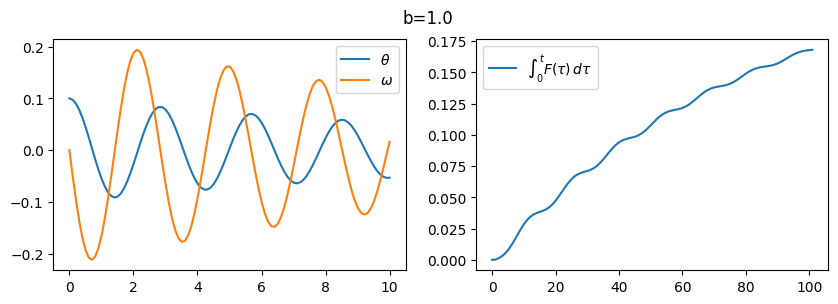

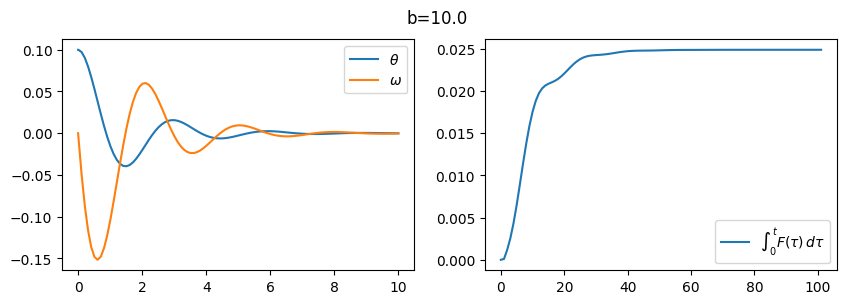

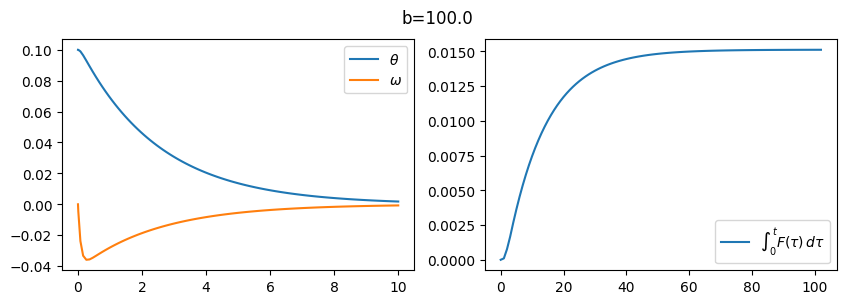

In [20]:
plot_response(1.0, context)
plot_response(10.0, context)
plot_response(100.0, context)

For optimization, we can create a more efficient forward function that doesn't do any plotting and returns the final value of the objective $\int_0^{t_{max}} F(t) \,dt$.

In [21]:
def forward(optvars, context):
    b = optvars[0]
    plant_subcontext = context[plant.system_id]
    plant_new_subcontext = plant_subcontext.with_parameter("b", b)

    context = context.with_subcontext(plant.system_id, plant_new_subcontext)

    options = SimulatorOptions(enable_autodiff=True, max_major_steps=1000, max_minor_step_size=0.1)
    sol = collimator.simulate(diagram, context, (0.0, t_max), options=options)
    objective_function = sol.context[diagram["objective"].system_id].continuous_state

    return objective_function


opt_func = jax.jit(partial(forward, context=context))

### Optimization with `scipy` routines

We can now minimize our objective function to find the optimal $b$. 

In [22]:
res = minimize(
    opt_func,
    jnp.array([10.0]),
    # jac=jax.grad(opt_func),
    method="BFGS",
    options={"gtol": 1e-08},
)

b_opt = res.x[0]
b_critical = jnp.sqrt(4 * config["m"] ** 2 * config["g"] * config["L"] ** 3)
print(f"Optimal damping coefficient: {b_opt}")
print(
    f"Critical damping coefficient for linear pemdulum with sin(theta) ~ theta approx: {b_critical}"
)

Optimal damping coefficient: 43.02513035255864
Critical damping coefficient for linear pemdulum with sin(theta) ~ theta approx: 35.435575344560164


We can look how the response with the optimal $b$ looks like.

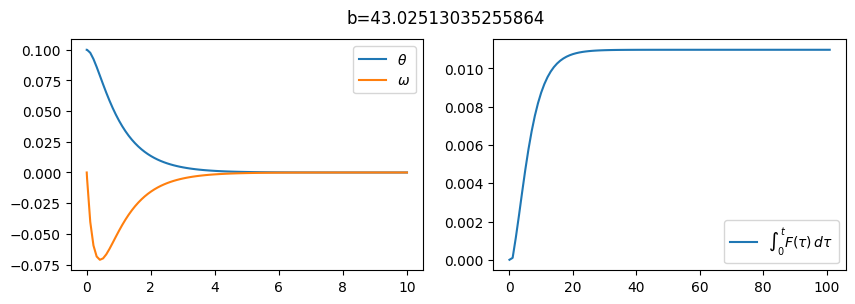

In [23]:
plot_response(b_opt, context)

This looks like a system close to critical damping. 

### Optimization with `JAX` routines

One may user JAX or IPOPT routines in a similar manner.

In [24]:
res = minimize_jax(opt_func, jnp.array([10.0]), method="BFGS", options={"gtol": 1e-08})

b_opt = res.x[0]
b_critical = jnp.sqrt(4 * config["m"] ** 2 * config["g"] * config["L"] ** 3)
print(f"Optimal damping coefficient: {b_opt}")
print(
    f"Critical damping coefficient for linear pemdulum with sin(theta) ~ theta approx: {b_critical}"
)

Optimal damping coefficient: 43.025648701831074
Critical damping coefficient for linear pemdulum with sin(theta) ~ theta approx: 35.435575344560164
